In [68]:
import os
import random
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import scipy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [34]:
# Define paths
main_folder = '/home/shuruyi/Documents/qgis/google_satelite/extracted_images/'
train = '/home/shuruyi/Documents/qgis/google_satelite/train'
valid = '/home/shuruyi/Documents/qgis/google_satelite/validation'
test = '/home/shuruyi/Documents/qgis/google_satelite/test'

# Create train, validation, and test directories if they don't exist
os.makedirs(train, exist_ok=True)
os.makedirs(valid, exist_ok=True)
os.makedirs(test, exist_ok=True)

# List all TIFF files in the main folder
tif_files = [f for f in os.listdir(main_folder) if f.endswith('.tif')]

# Define the ratio for train-validation-test split (e.g., 70-20-10 split)
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 1 - train_ratio - valid_ratio

# Randomly shuffle the list of files
random.shuffle(tif_files)

# Split the data into train, validation, and test sets
train_files, test_files = train_test_split(tif_files, test_size=test_ratio, random_state=42)
train_files, valid_files = train_test_split(train_files, test_size=valid_ratio/(train_ratio + valid_ratio), random_state=42)

# Move files to train, validation, and test folders
for file in train_files:
    src = os.path.join(main_folder, file)
    # Extract label from the filename
    label = int(file.split('_label_')[-1].split('.')[0])
    if label == 0:
        dst = os.path.join(train, 'not-pinus', file)
    else:
        dst = os.path.join(train, 'pinus', file)
    shutil.move(src, dst)

for file in valid_files:
    src = os.path.join(main_folder, file)
    # Extract label from the filename
    label = int(file.split('_label_')[-1].split('.')[0])
    if label == 0:
        dst = os.path.join(valid, 'not-pinus', file)
    else:
        dst = os.path.join(valid, 'pinus', file)
    shutil.move(src, dst)

for file in test_files:
    src = os.path.join(main_folder, file)
    dst = os.path.join(test, file)
    shutil.move(src, dst)

In [35]:
train_files

['extracted_roi_646_label_1.tif',
 'extracted_roi_923_label_1.tif',
 'extracted_roi_560_label_1.tif',
 'extracted_roi_434_label_0.tif',
 'extracted_roi_766_label_1.tif',
 'extracted_roi_75_label_0.tif',
 'extracted_roi_159_label_1.tif',
 'extracted_roi_943_label_1.tif',
 'extracted_roi_217_label_1.tif',
 'extracted_roi_851_label_0.tif',
 'extracted_roi_619_label_0.tif',
 'extracted_roi_121_label_1.tif',
 'extracted_roi_196_label_0.tif',
 'extracted_roi_840_label_0.tif',
 'extracted_roi_142_label_0.tif',
 'extracted_roi_6_label_0.tif',
 'extracted_roi_520_label_0.tif',
 'extracted_roi_785_label_0.tif',
 'extracted_roi_202_label_0.tif',
 'extracted_roi_476_label_1.tif',
 'extracted_roi_303_label_1.tif',
 'extracted_roi_845_label_0.tif',
 'extracted_roi_305_label_1.tif',
 'extracted_roi_589_label_0.tif',
 'extracted_roi_495_label_1.tif',
 'extracted_roi_504_label_1.tif',
 'extracted_roi_871_label_0.tif',
 'extracted_roi_327_label_0.tif',
 'extracted_roi_530_label_1.tif',
 'extracted_roi_6

In [40]:
# CNN model parameters
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
epochs = 14
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train', 'valid', and 'test' are paths to the directories containing respective data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Print training and validation loss and accuracy
print("Training Loss:", history.history['loss'])
print("Training Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

Found 1527 images belonging to 2 classes.


Found 437 images belonging to 2 classes.
Epoch 1/14
48/48 [==============================] - 254s 5s/step - loss: 0.5924 - accuracy: 0.6758 - val_loss: 1.1452 - val_accuracy: 0.6250
Epoch 2/14


/home/shuruyi/Documents/git/IC/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 304s 6s/step - loss: 0.4838 - accuracy: 0.7806 - val_loss: 0.3824 - val_accuracy: 0.8438
Epoch 3/14
48/48 [==============================] - 304s 6s/step - loss: 0.3739 - accuracy: 0.8330 - val_loss: 0.2748 - val_accuracy: 0.8774
Epoch 4/14
48/48 [==============================] - 360s 8s/step - loss: 0.2964 - accuracy: 0.8788 - val_loss: 0.2526 - val_accuracy: 0.9038
Epoch 5/14
48/48 [==============================] - 286s 6s/step - loss: 0.2960 - accuracy: 0.8743 - val_loss: 0.3019 - val_accuracy: 0.8846
Epoch 6/14
48/48 [==============================] - 253s 5s/step - loss: 0.2364 - accuracy: 0.9005 - val_loss: 0.2005 - val_accuracy: 0.9062
Epoch 7/14
48/48 [==============================] - 237s 5s/step - loss: 0.2136 - accuracy: 0.9142 - val_loss: 0.1620 - val_accuracy: 0.9399
Epoch 8/14
48/48 [==============================] - 242s 5s/step - loss: 0.1680 - accuracy: 0.9345 - val_loss: 0.1907 - val_accuracy: 0.9183
Epoch 9/14
48/48 [======

In [62]:
# Extract labels from file names
test_labels = [int(file.split('_label_')[-1].split('.')[0]) for file in test_files]

# Create DataFrame with file paths and labels
test_df = pd.DataFrame({'File_Name': test_files, 'Label': test_labels})

# Get list of all .tif files in the test folder
test_image_files = [os.path.join(test, f) for f in os.listdir(test) if f.endswith('.tif')]

# Prepare data for testing
test_images = []
for image_path in test_image_files:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    test_images.append(img)

# Convert the list of images to numpy array
test_images = np.array(test_images)

# Get predictions for the test data
predictions = model.predict(test_images)

# Define the file path where you want to save the CSV file
csv_filename = '/home/shuruyi/Documents/qgis/google_satelite/test_labels.csv'

# Save the true_pred DataFrame to a CSV file
true_pred = pd.read_csv(csv_filename)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Create a DataFrame for binary predictions
binary_predictions_df = pd.DataFrame(binary_predictions, columns=['Binary_Predictions'])
binary_predictions_df

# Concatenate train_df with binary_predictions_df
concatenated_df = pd.concat([test_df.File_Name, binary_predictions_df], axis=1)

# Print the binary predictions
concatenated_df

7/7 [==============================] - 0s 66ms/step


,File_Name,Binary_Predictions
0,extracted_roi_17_label_1.tif,1
1,extracted_roi_634_label_1.tif,0
2,extracted_roi_674_label_0.tif,0
3,extracted_roi_242_label_0.tif,1
4,extracted_roi_31_label_1.tif,0
...,...,...
214,extracted_roi_905_label_1.tif,0
215,extracted_roi_925_label_1.tif,0
216,extracted_roi_85_label_0.tif,0
217,extracted_roi_339_label_0.tif,0


In [63]:
# Print the DataFrame
test_df

,File_Name,Label
0,extracted_roi_17_label_1.tif,1
1,extracted_roi_634_label_1.tif,1
2,extracted_roi_674_label_0.tif,0
3,extracted_roi_242_label_0.tif,0
4,extracted_roi_31_label_1.tif,1
...,...,...
214,extracted_roi_905_label_1.tif,1
215,extracted_roi_925_label_1.tif,1
216,extracted_roi_85_label_0.tif,0
217,extracted_roi_339_label_0.tif,0


In [65]:
# Assuming true labels are stored in a variable called true_labels
true_labels = test_df['Label'].values  # Extracting true labels from the DataFrame

# Assuming predicted binary values are in the concatenated_df DataFrame under 'Binary_Predictions' column
predicted_values = concatenated_df['Binary_Predictions'].values  # Extracting predicted binary values

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(true_labels, predicted_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.42%


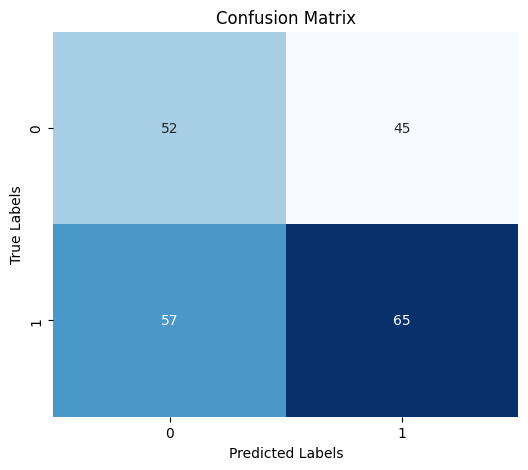

In [73]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_values)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()